In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
cols = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT",
    "MEDV",
]
data = pd.read_csv(url, header=None, names=cols, delim_whitespace=True)
data.dropna(inplace=True)

In [3]:
def IQR_method (df,n=1):
    outlier_list = []
    
    for column in df.columns:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column],75)
        IQR = Q3 - Q1
        limit = 1.5 * IQR
        aux_list = df[(df[column] < Q1 - limit) | (df[column] > Q3 + limit )].index
        outlier_list.extend(aux_list)
        
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    return multiple_outliers

In [4]:
Outliers_IQR = IQR_method(data,1)
data = data.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

In [5]:
X = data.drop("MEDV", axis=1)
y = data["MEDV"]

In [6]:
model = LinearRegression()
n_features_to_select = 3

rfe = RFE(model, n_features_to_select=n_features_to_select)
X_selected = rfe.fit_transform(X, y)

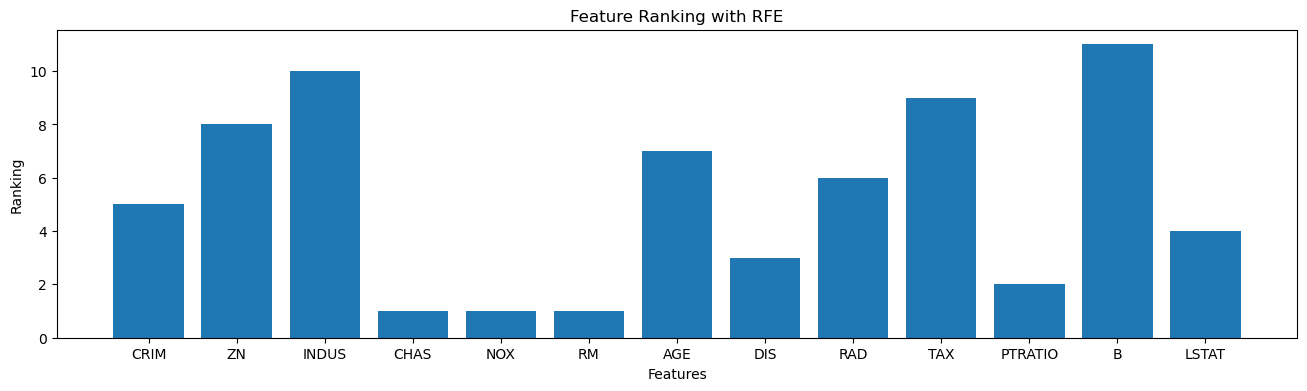

In [7]:
feature_names = X.columns

plt.figure(figsize=(16, 4))
plt.bar(range(len(rfe.ranking_)), rfe.ranking_, tick_label=feature_names)
plt.title("Feature Ranking with RFE")
plt.xlabel("Features")
plt.ylabel("Ranking")
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

kf = KFold(n_splits=5,shuffle=False)

In [9]:
lr_pipe = Pipeline([("scaler", StandardScaler()), ("regressor", LinearRegression())])

lr_params = {
    "scaler__with_mean": [True, False],
    "scaler__with_std": [True, False],
    "regressor__fit_intercept": [True, False],
    "regressor__copy_X": [True, False],
    "regressor__positive": [True, False],
}

lr_grid = GridSearchCV(lr_pipe, lr_params, cv=kf, n_jobs=-1, verbose=1,scoring='neg_mean_squared_error')
lr_grid.fit(X_train, y_train)
lr_pred = lr_grid.best_estimator_.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [10]:
rf_pipe = Pipeline(
    [("scaler", StandardScaler()), ("regressor", RandomForestRegressor())]
)

rf_params = {
    "scaler__with_mean": [True, False],
    "scaler__with_std": [True, False],
    "regressor__n_estimators": [10, 50, 100, 200],
    "regressor__criterion": [
        "squared_error",
        "absolute_error",
        "friedman_mse",
        "poisson",
    ],
    "regressor__max_depth": [None, 10, 20, 30],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
}

rf_grid = RandomizedSearchCV(rf_pipe, rf_params, cv=kf, n_jobs=-1, verbose=1, n_iter=200,scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
rf_pred = rf_grid.best_estimator_.predict(X_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [11]:
mlp_pipe = Pipeline([("scaler", StandardScaler()), ("regressor", MLPRegressor())])

mlp_params = {
    "scaler__with_mean": [True, False],
    "scaler__with_std": [True, False],
    "regressor__hidden_layer_sizes": [(100,), (50, 50), (50, 100, 50)],
    "regressor__activation": ["relu", "tanh"],
    "regressor__solver": ["adam"],
    "regressor__alpha": np.linspace(0, 0.01, 10),
    "regressor__batch_size": [32, 64, 128],
    "regressor__learning_rate": ["constant", "adaptive"],
    "regressor__max_iter": [1000, 2000],
    "regressor__tol": [0.0001],
    "regressor__early_stopping": [True, False],
    "regressor__beta_1": np.linspace(0.9, 0.999, 5),
    "regressor__beta_2": np.linspace(0.999, 0.9999, 5),
    "regressor__epsilon": [1e-08, 1e-07, 1e-06],
}

mlp_grid = RandomizedSearchCV(
    mlp_pipe, mlp_params, cv=kf, n_jobs=-1, verbose=1, n_iter=200,scoring='neg_mean_squared_error'
)
mlp_grid.fit(X_train, y_train)
mlp_pred = mlp_grid.best_estimator_.predict(X_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [12]:
elastic_pipe = Pipeline([("scaler", StandardScaler()), ("regressor", ElasticNet())])

elastic_params = {
    "scaler__with_mean": [True, False],
    "scaler__with_std": [True, False],
    "regressor__alpha": np.linspace(0, 1, 10),
    "regressor__l1_ratio": np.linspace(0, 1, 10),
    "regressor__fit_intercept": [True, False],
    "regressor__precompute": [True, False],
    "regressor__copy_X": [True, False],
    "regressor__positive": [True, False],
    "regressor__selection": ["cyclic", "random"],
    "regressor__warm_start": [True, False],
    "regressor__tol": [0.0001],
}

elastic_grid = GridSearchCV(elastic_pipe, elastic_params, cv=kf, n_jobs=-1, verbose=1,scoring='neg_mean_squared_error')
elastic_grid.fit(X_train, y_train)
elastic_pred = elastic_grid.best_estimator_.predict(X_test)

Fitting 5 folds for each of 25600 candidates, totalling 128000 fits


c:\Users\herbe\anaconda3\envs\TS_env\Lib\site-packages\sklearn\pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\herbe\anaconda3\envs\TS_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\herbe\anaconda3\envs\TS_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4340.876171330368, tolerance: 17.09374
  model = cd_fast.enet_coordinate_descent_gram(


In [13]:
df_pred = pd.DataFrame(
    {
        "lr": lr_pred,
        "rf": rf_pred,
        "mlp": mlp_pred,
        "elastic": elastic_pred,
        "y": y_test,
    }
)

In [14]:
df_pred = df_pred.melt(id_vars=["y"])

In [15]:
df_erro = df_pred.groupby("variable").apply(
    lambda x: mean_squared_error(x["y"], x["value"])
).reset_index().rename(columns={0: "mean_squared_error"}).merge(
    df_pred.groupby("variable")
    .apply(lambda x: mean_absolute_error(x["y"], x["value"]))
    .reset_index()
    .rename(columns={0: "mean_absolute_error"})
).merge(
    df_pred.groupby("variable")
    .apply(lambda x: r2_score(x["y"], x["value"]))
    .reset_index()
    .rename(columns={0: "r2_score"})
).merge(
    df_pred.groupby("variable")
    .apply(lambda x: mean_absolute_percentage_error(x["y"], x["value"]))
    .reset_index()
    .rename(columns={0: "mean_absolute_percentage_error"})
)

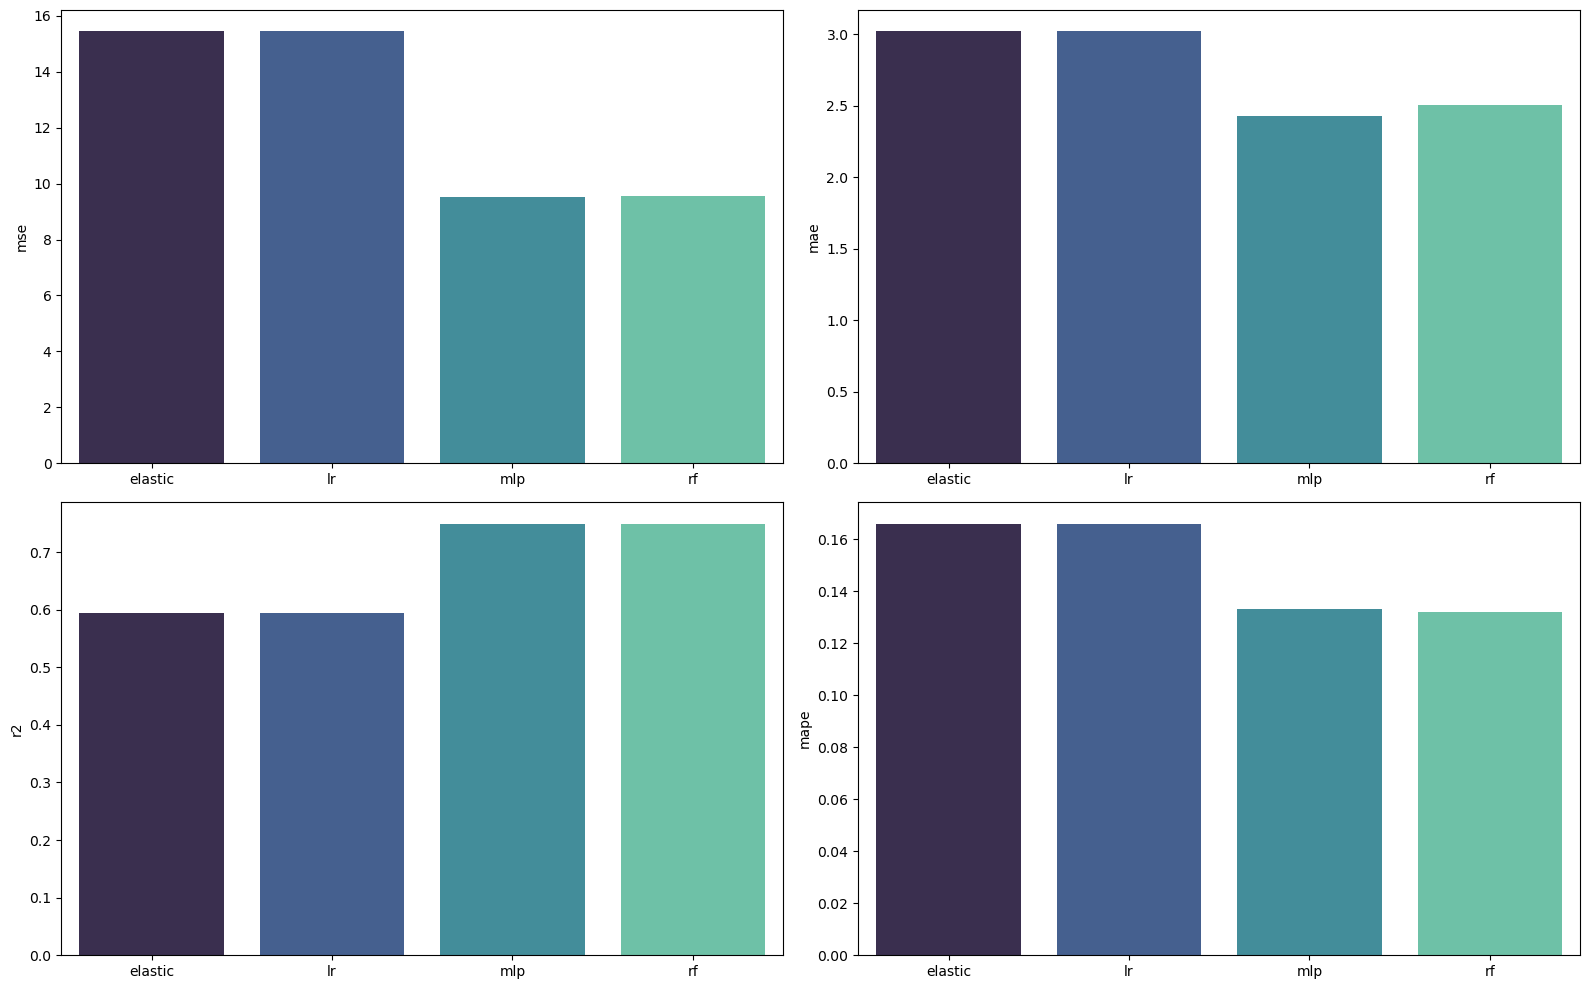

In [16]:
fig,ax = plt.subplots(2,2,figsize=(16,10))
sns.barplot(x="variable",y='mean_squared_error',data=df_erro,ax=ax[0][0],palette="mako").set(xlabel='',ylabel='mse')
sns.barplot(x="variable",y='mean_absolute_error',data=df_erro,ax=ax[0][1],palette="mako").set(xlabel='',ylabel='mae')
sns.barplot(x="variable",y='r2_score',data=df_erro,ax=ax[1][0],palette="mako").set(xlabel='',ylabel='r2')
sns.barplot(x="variable",y='mean_absolute_percentage_error',data=df_erro,ax=ax[1][1],palette="mako").set(xlabel='',ylabel='mape')
plt.tight_layout()